In [1]:
import warnings
import sys

warnings.filterwarnings("ignore")
sys.path.append('../../')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from PertCF import *
import pandas as pd
import numpy as np
import pickle
import random

In [3]:
# Set random seed
random_state = random.randint(0, 100)
# Concept name
concept = 'knowledge'
column_names = ['STG','SCG','STR','LPR','PEG','UNS']
class_names = ['0','1','2','3']

df =  pd.read_csv('./data/userKnowledgeModeling.csv', names=column_names, header=0, sep=";")

# UNS is the label (categoric)
df = df.astype({'UNS':'string'})

# Drop unwanted columns and nan rows
# df = df.drop(['race', 'native_country', 'education_num'], axis=1)
# df = df.replace('?',np.nan).dropna()

In [4]:
for c in class_names:
    print(c, ': ', len(df[df['UNS']==c]))

0 :  50
1 :  129
2 :  122
3 :  102


In [5]:
cat_feat = []

train_cols = df.columns[0:-1]
label = df.columns[-1]


for f in cat_feat:
    df[f] = df[f].astype("category")

X = df[train_cols]
y = df[label]

# Split dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state)  

train = X_train.join(y_train)
test = X_test.join(y_test)

In [6]:
# Save datasets
train.to_pickle("./Data/unm_train.pkl")
test.to_pickle("./Data/unm_test.pkl")

---

In [7]:
def rev(dic):
    return {v: k for k, v in dic.items()}

# from categoric features to numeric features with maps
# from numeric features to categoric features with inv_maps
def encode(df, maps):
    for i in cat_feat:
        df[i] = df[i].map(maps[i]).astype('float')
    return df

maps = {}
inv_maps = {}

In [8]:
# encoding for training the model
X_en = encode(X.copy(), maps)
X_train_en, X_test_en = encode(X_train.copy(), maps), encode(X_test.copy(), maps)
train_en = encode(train.copy(), maps)
test_en = encode(test.copy(), maps)


In [9]:
# Model
model = RandomForestClassifier()#GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=random_state)
model = model.fit(X_train_en, y_train)
print('Score:', model.score(X_test_en, y_test))

# save model
model_path = './Model/model_rf.pkl'
pickle.dump(model, open(model_path, "wb"))

# load model
#loaded_model = pickle.load(open(model_path, "rb"))

Score: 0.9512195121951219


In [10]:
# Model
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=random_state)
model = model.fit(X_train_en, y_train)
print('Score:', model.score(X_test_en, y_test))

# save model
model_path = './Model/model_GBC.pkl'
pickle.dump(model, open(model_path, "wb"))

# load model
#loaded_model = pickle.load(open(model_path, "rb"))

Score: 0.975609756097561


In [11]:
def shapValues(X_train, model, class_names, label):
        
        if len(X_train)>300:
            df = X_train.sample(300)
        else:
            df = X_train.copy()
        
        for column in df.columns:
            if df[column].dtype not in ['int64']:
                df[column] = df[column].astype('category').cat.codes

        # Create shap kernel explainer using model and training data
        explainer = shap.KernelExplainer(model.predict_proba, df)

        # Shap values calculated by explainer
        shap_values = explainer.shap_values(df)


        # Create df from mean of shap values (map the order of features and classes)
        mean_classes = []
        for i in range(len(shap_values)):
            mean_classes.append(np.mean(np.abs(shap_values[i]), axis=0))

        shap_df = pd.DataFrame(mean_classes, index=class_names, 
                                    columns=X_train.columns.tolist())

        num_class = len(shap_df)

        # Wheight of label = 0 
        shap_df[label] = np.zeros(num_class)
        
        # normalize shap values
        shap_df =  shap_df.div(shap_df.sum(axis=1), axis=0)   
        
        return shap_df

In [12]:
shap_df = shapValues(X_train, model, class_names, label)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/300 [00:00<?, ?it/s]

In [13]:
shap_df

,STG,SCG,STR,LPR,PEG,UNS
0,0.063793,0.064516,0.179009,0.268393,0.424290,0.0
1,0.066289,0.019689,0.251258,0.414016,0.248748,0.0
2,0.170029,0.132444,0.252231,0.197508,0.247788,0.0
3,0.039136,0.046183,0.219762,0.230542,0.464376,0.0


In [14]:
shap_df.to_pickle("./temp_files/shap_df.pkl")

<AxesSubplot: >

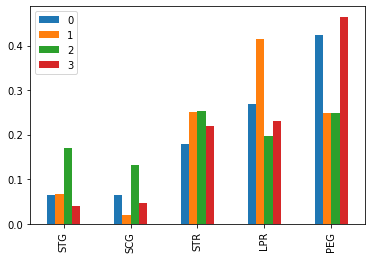

In [15]:
shap_df[['STG','SCG','STR','LPR','PEG']].T.plot.bar()

In [14]:
a = pd.read_pickle("./temp_files/shap_df.pkl")

In [15]:
a.index = ['class 0','class 1','class 2','class 3']

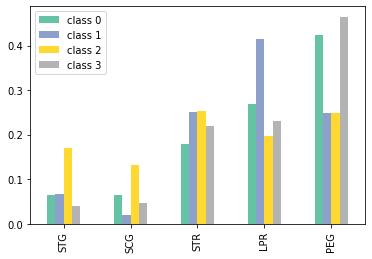

In [50]:
ag = a[['STG','SCG','STR','LPR','PEG']].T.plot.bar(cmap='Set2')
ag.figure.savefig('./Output/img/shap.png', dpi=1200, bbox_inches='tight')